In [6]:

from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# this is a slightly modified code from https://github.com/TeaPearce/Conditional_Diffusion_MNIST



class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep, 
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)
        
        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.n_classes)
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask
        
        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out


def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }


class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))

    def sample(self, n_sample, size, device, guide_w = 0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0,10).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store


In [8]:
n_T = 400 
device = "cuda:0" if torch.cuda.is_available() else "cpu"  
n_classes = 10
n_feat = 128

ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
ddpm.to(device)

model_path = 'model_39.pth'  
ddpm.load_state_dict(torch.load(model_path, map_location=device)) 
ddpm.to(device)
ddpm.eval()  




/tmp/ipykernel_18857/3385481233.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ddpm.load_state_dict(torch.load(model_path, map_location=device))


DDPM(
  (nn_model): ContextUnet(
    (init_conv): ResidualConvBlock(
      (conv1): Sequential(
        (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
    )
    (down1): UnetDown(
      (model): Sequential(
        (0): ResidualConvBlock(
          (conv1): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): GELU(approximate='none')
          )
          (conv2): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 

In [9]:
# Combines the noise estimate for rotations
def rot_transform(image, label1, label2, t_is,context_mask):
    with torch.no_grad():
        # t = 0.5
        dims = (2, 3)  # Dimensions for rotation
        k = 2  # Rotation angle (e.g., 1 for 90 degrees)
        
        # Rotate the image for the first view
        transf_1 = torch.rot90(image, k=k, dims=dims)
        view_1 = ddpm.nn_model(transf_1, label1, t_is, context_mask)

        # Rotate back the noise estimate 
        view_1 = torch.rot90(view_1, k=-k, dims=dims)  

        # Second view without transformation
        view_2 = ddpm.nn_model(image, label2, t_is, context_mask)

        # Combine noise estimates (ensure shape compatibility)
        # return 0.5 * (view_1 + t*view_2)
        return 0.5*view_1 + 0.5*view_2

In [10]:
# # torch.manual_seed(1)
# x_i = torch.randn(1, 1,28,28).to(device)  # x_T ~ N(0, 1), sample initial noise
# # print(x_i)
# digit = 3
# # label = torch.tensor([digit])
# label1 = torch.tensor([2])

# label2 = torch.tensor([6])
# context_mask = torch.tensor([0.0])

# for i in range(ddpm.n_T, 0, -1):
#     with torch.no_grad():
#         t_is = torch.tensor([i / ddpm.n_T]).to(device)

#         z = torch.randn(1,1,28,28).to(device) if i > 1 else 0
#         # eps = ddpm.nn_model(x_i, label, t_is, torch.tensor([0.0])) # this line gets changed
#         # These two should be equivalent
#         eps = rot_transform(x_i,label1,label2,t_is,context_mask )
#         # eps = ddpm.nn_model(x_i, label2, t_is, torch.tensor([0.0]))

#         x_i = (
#                 ddpm.oneover_sqrta[i] * (x_i - eps * ddpm.mab_over_sqrtmab[i])
#                 + ddpm.sqrt_beta_t[i] * z
#             )
# # x_i = torch.rot90(x_i,dims=(2,3))
# x_i=x_i.view(28,28).detach().cpu().numpy()
# # plt.imshow(x_i, cmap='gray')
# # plt.imshow(np.rot90(x_i,axes=(0,1),k=2 ), cmap="gray")


# f = plt.figure()
# f.add_subplot(1,2, 1)
# plt.imshow(x_i, cmap='gray')
# f.add_subplot(1,2, 2)
# plt.imshow(np.rot90(x_i,2), cmap='gray')
# plt.show(block=True)

In [11]:
def rotate_puzzle(direction):
    if direction not in [1, -1]:
        raise ValueError("Direction must be 1 (clockwise) or -1 (anti-clockwise).")
        
    def rotate(images):
        """
        Rotates the quadrants of a batch of images around their centers.
        Args:
            images (torch.Tensor): A batch of 2D images of shape (B, C, H, W).
        Returns:
            torch.Tensor: A batch of rotated images of shape (B, C, H, W).
        """
        if len(images.shape) != 4:
            raise ValueError("Input images must have 4 dimensions (B, C, H, W).")
            
        B, C, H, W = images.shape
        mid_H, mid_W = H // 2, W // 2
        
        # Extract quadrants
        q1 = images[:, :, :mid_H, :mid_W]      # top-left
        q2 = images[:, :, :mid_H, mid_W:]      # top-right
        q3 = images[:, :, mid_H:, :mid_W]      # bottom-left
        q4 = images[:, :, mid_H:, mid_W:]      # bottom-right

        # Rotate each quadrant 90 degrees in specified direction
        if direction == 1:  # Clockwise
            rotated = torch.rot90(images, k=-1, dims=[2, 3])
        else:  # Anti-clockwise
            rotated = torch.rot90(images, k=1, dims=[2, 3])
            
        # Extract rotated quadrants
        rq1 = rotated[:, :, :mid_H, :mid_W]
        rq2 = rotated[:, :, :mid_H, mid_W:]
        rq3 = rotated[:, :, mid_H:, :mid_W]
        rq4 = rotated[:, :, mid_H:, mid_W:]
        
        # Reconstruct image with rotated quadrants
        top = torch.cat([rq1, rq2], dim=3)
        bottom = torch.cat([rq3, rq4], dim=3)
        result = torch.cat([top, bottom], dim=2)
        
        return result
    
    return rotate

def rotate_image_quadrants_numpy_2d(images, direction='clockwise'):
    """
    Rotate the quadrants of a batch of 2D images around their centers.
    Args:
        images (numpy.ndarray): The input image array of shape (B, H, W)
        direction (str): Direction of rotation ('clockwise' or 'anti-clockwise')
    Returns:
        numpy.ndarray: The rotated image array of shape (B, H, W)
    """
    if len(images.shape) != 3:
        raise ValueError("Input images must have 3 dimensions (B, H, W).")
        
    B, H, W = images.shape
    mid_H, mid_W = H // 2, W // 2
    
    # Extract quadrants
    q1 = images[:, :mid_H, :mid_W]
    q2 = images[:, :mid_H, mid_W:]
    q3 = images[:, mid_H:, :mid_W]
    q4 = images[:, mid_H:, mid_W:]
    
    # Rotate each quadrant 90 degrees
    k = 1 if direction == 'anti-clockwise' else -1
    rq1 = np.rot90(q1, k=k, axes=(1, 2))
    rq2 = np.rot90(q2, k=k, axes=(1, 2))
    rq3 = np.rot90(q3, k=k, axes=(1, 2))
    rq4 = np.rot90(q4, k=k, axes=(1, 2))
    
    # Reconstruct image with rotated quadrants
    top = np.concatenate([rq1, rq2], axis=2)
    bottom = np.concatenate([rq3, rq4], axis=2)
    result = np.concatenate([top, bottom], axis=1)
    
    return result

In [12]:
# set seed
# list of transformation I can try
# 180 rotation
# 90 rotation
# skews
# symmetry/reflection
# random orthogonal matrix
# two identities
# two views?
# three views
# hmm, I really don't know their signature.

def rotate(k):
    def rotation_func(x):
        return torch.rot90(x, k = k, dims = (2,3))
    return rotation_func
def reflect_left_right(x):
    return torch.flip(x, dims = [-1])
def reflect_up_down(x):
    return torch.flip(x, dims = [-2])
def identity(x):
    return x


def generate_images(n_images, label1, label2 = None, transformation = None, transf_inverse = None):
    x_i = torch.randn(n_images, 1,28,28).to(device)  # x_T ~ N(0, 1), sample initial noise
    # print(x_i)
    label1 = torch.tensor(label1).to(device)
    label = label1
    # if label2 != None:
    label2 = torch.tensor(label2).to(device)

    context_mask = torch.zeros_like(label1).to(device)


    for i in range(ddpm.n_T, 0, -1):
        with torch.no_grad():
            t_is = torch.tensor([i / ddpm.n_T]*n_images).to(device)

            z = torch.randn(n_images,1,28,28).to(device) if i > 1 else 0
            if transformation == None:
                eps = ddpm.nn_model(x_i, label, t_is, context_mask) # this line gets changed
            # eps = vis_transform(x_i,label1,label2,t_is, ddpm.nn_model)
            else:
                # transformed image(rotated, reflected etc.)
                transf_image = transformation(x_i)
                eps_2 = ddpm.nn_model(transf_image, label2, t_is, context_mask)
                eps_2 = transf_inverse(eps_2)
                eps_1 = ddpm.nn_model(x_i,label1, t_is, context_mask)
                eps = 0.5*eps_1 + 0.5*eps_2
                # eps = transformation(x_i, label1,label2, t_is, context_mask)
                # eps = rot_transform(x_i, label1, label2, t_is, context_mask)

            x_i = (
                    ddpm.oneover_sqrta[i] * (x_i - eps * ddpm.mab_over_sqrtmab[i])
                    + ddpm.sqrt_beta_t[i] * z
                )

    return x_i.view(n_images,28,28).detach().cpu().numpy()

def plot_images(images):
    f = plt.figure(figsize=(20,20))
    n_images = images.shape[0]
    for i in range(n_images):
        f.add_subplot(1,n_images, i+1)
        plt.axis('off')
        plt.imshow(images[i], cmap='gray')
    plt.show()


In [13]:
torch.manual_seed(9)
# setseed
# experiments with 180 rotation
n_batches = 10
for i in range(n_batches):
    n_images = 10
    images = generate_images(n_images,[6]*n_images, [2]*n_images, transformation=rotate(2), transf_inverse= rotate(-2))
    print("Images\n")
    plot_images(images)
    print("Transformed images\n")
    plot_images(np.rot90(images, k=2, axes=(1,2)))

KeyboardInterrupt: 

In [3]:
rec_6 = [1,2,3,8,16,22,28,37,39,44,48,51,55,65,73,78,79,80,81,82,83,90,91,92,98]
rec_2 = [2,5,7,12,14,17,19,20,40,57,60,62,64,67,68,69,70,72,88,95]
print(len(rec_6))
print(len(rec_2))
def count_common_elements(list1, list2):
    # Method 1: Using sets intersection
    return len(set(list1) & set(list2))
print(count_common_elements(rec_2,rec_6))

25
20
1


In [4]:
# torch.manual_seed(9)
# setseed
# experiments with 180 rotation
# n_batches = 10
# for i in range(n_batches):
#     n_images = 10
#     images = generate_images(n_images,[4]*n_images, [4]*n_images, transformation=rotate(2), transf_inverse= rotate(-2))
#     print("Images\n")
#     plot_images(images)
#     print("Transformed images\n")
#     plot_images(np.rot90(images, k=2, axes=(1,2)))


rec_4 = [0,1,2,3,6,10,12,13,14,16,17,18,19,20,23,27,28,31,34,37,38,42,45,46,47,54,55,56,58,59,60,61,63,64,65,66,73,74,86,87,88,90,91,95]
rec_4_transform =[1,2,3,4,5,9,10,12,14,16,18,19,23,28,37,42,46,53,54,55,59,60,61,63,64,65,67,68,70,71,72,74,76,77,80,86,87,91,93,95,98] 
print(len(rec_4),len(rec_4_transform),count_common_elements(rec_4,rec_4_transform))

44 41 27


In [ ]:
torch.manual_seed(9)
# setseed
# experiments with 180 rotation
n_batches = 10
for i in range(n_batches):
    n_images = 10
    images = generate_images(n_images,[6]*n_images, [9]*n_images, transformation=rotate(2), transf_inverse= rotate(-2))
    print("Images\n")
    plot_images(images)
    print("Transformed images\n")
    plot_images(np.rot90(images, k=2, axes=(1,2)))

Images,batch=0



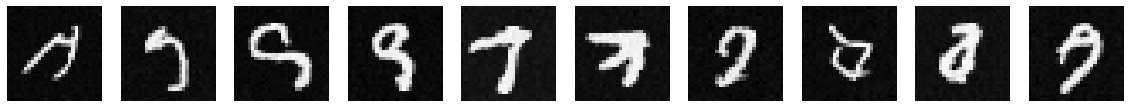

Transformed images

Images,batch=1



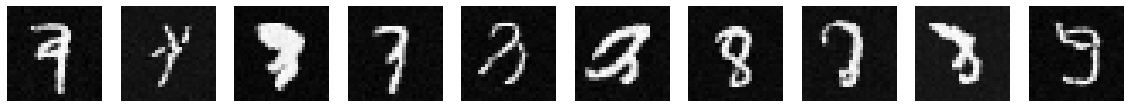

Transformed images



In [ ]:
torch.manual_seed(9)
# setseed
# experiments with 180 rotation
n_batches = 10
img = []
for i in range(n_batches):
    n_images = 10
    images = generate_images(n_images,[7]*n_images, [8]*n_images, transformation=rotate(2), transf_inverse= rotate(-2))
    img.append(images)
    print(f"Images,batch={i}\n")
    plot_images(images)
    print("Transformed images\n")
    # plot_images(np.rot90(images, k=2, axes=(1,2)))

rec_7 = [4,13,22]

In [ ]:
for i in range(len(img)):
    print(f"Images,batch={i}\n")
    plot_images(np.rot90(img[i], k=2, axes=(1,2)))

    

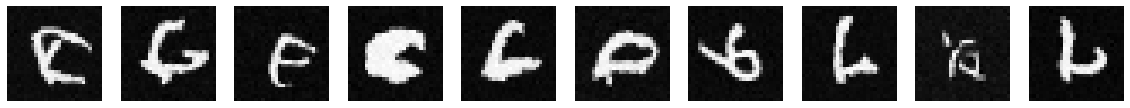

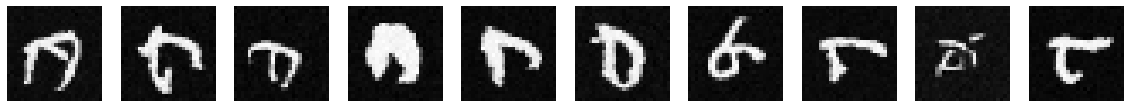

In [ ]:
torch.manual_seed(9)
# experiments with rotation 90
n_batches = 10
for i in range(n_batches):     
    n_images   
    images = generate_images(n_images,[4]*n_images, [9]*n_images, transformation=rotate(1), transf_inverse= rotate(-1))
    plot_images(images)
    plot_images(np.rot90(images, k=-1, axes=(1,2)))

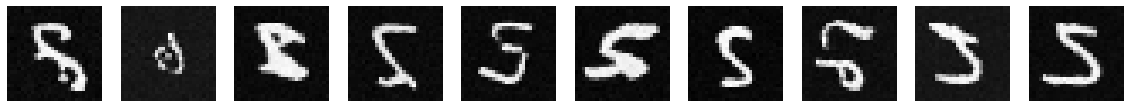

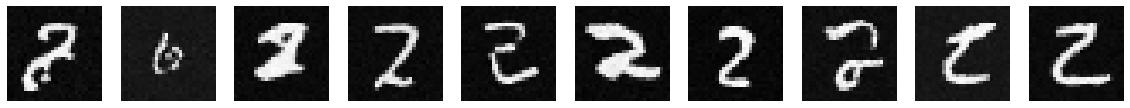

In [60]:
torch.manual_seed(9)
# setseed
# experiments with reflection(left-right)
n_batches = 10
for i in range(n_batches):
    n_images=10
    images = generate_images(n_images,[2]*n_images, [5]*n_images, transformation=reflect_left_right, transf_inverse= reflect_left_right)
    plot_images(images)
    plot_images(np.flip(images, axis=2))

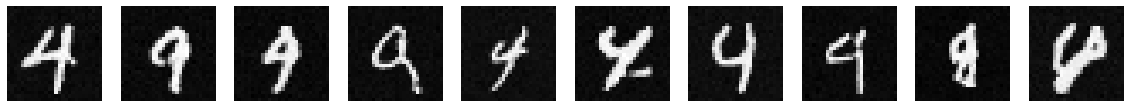

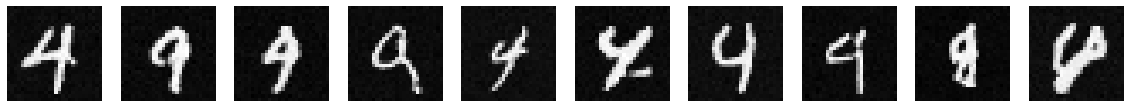

In [56]:
torch.manual_seed(9)
# setseed
# experiments with rotation
n_images=10
images = generate_images(n_images,[9]*n_images, [4]*n_images, transformation=identity,transf_inverse= identity)
plot_images(images)
# plot_images(np.flip(images, axis=2))


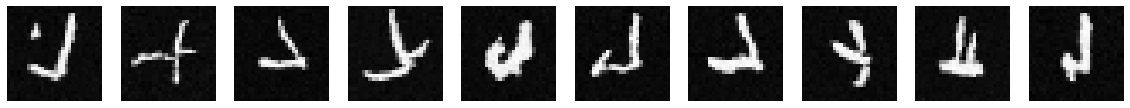

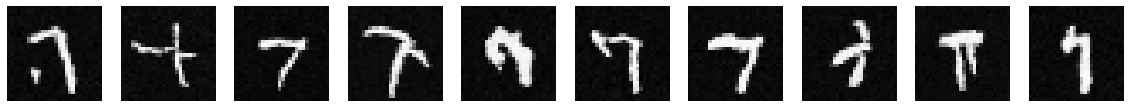

In [ ]:
# setseed
# experiments with rotation
n_images=10
images = generate_images(n_images,[7]*n_images, [4]*n_images, transformation=reflect_up_down,transf_inverse= reflect_up_down)
plot_images(images)
plot_images(np.flip(images,axis=1))

In [54]:
# setseed
# experiments with rotation
n_images=10
images = generate_images(n_images,[3]*n_images, [3]*n_images, transformation=reflect_left_right,transf_inverse= reflect_left_right)
plot_images(images)
plot_images(np.flip(images,axis=2))


KeyboardInterrupt: 

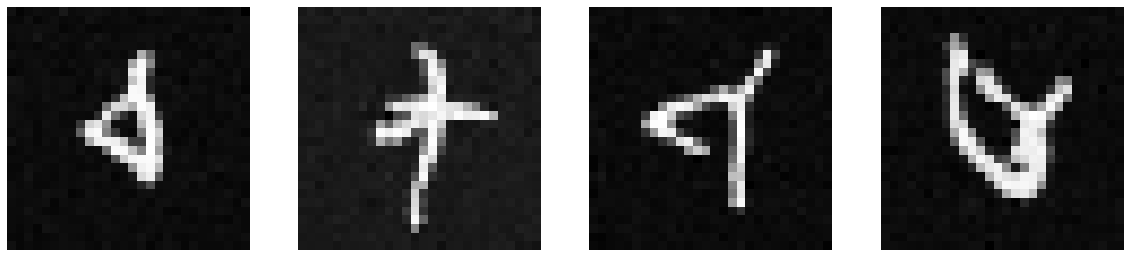

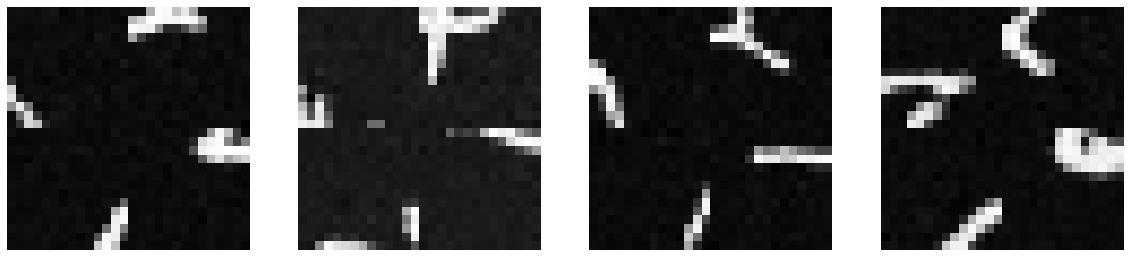

In [47]:
# setseed
# experiments with rotation
n_images=4
images = generate_images(n_images,[4]*n_images, [4]*n_images, transformation=rotate_puzzle(1),transf_inverse= rotate_puzzle(-1))
plot_images(images)
plot_images(rotate_image_quadrants_numpy_2d(images))
